In [1]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#for using gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make('CartPole-v1')
print(env.action_space, env.observation_space)
env.seed(101)
np.random.seed(101)

Discrete(2) Box(4,)


/home/oxygen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class Agent(nn.Module):
    def __init__(self, env, action_space, state_space):
        super(Agent, self).__init__()
        self.env = env
        self.a_s = action_space
        self.s_s = state_space
        self.h_s = 16
        self.fc1 = nn.Linear(self.s_s, self.h_s).to(device)
        self.fc2 = nn.Linear(self.h_s, self.a_s).to(device)
    
    def get_wights_dim(self):
        return (self.s_s+1)*self.h_s + (self.h_s+1)*self.a_s

    def adjust_to_weights(self,weights):
        end = self.s_s*self.h_s + self.h_s
        fc1_w = torch.from_numpy(weights[:self.s_s*self.h_s]).reshape(self.s_s, self.h_s)
        fc1_b = torch.from_numpy(weights[self.s_s*self.h_s:end])
        fc2_w = torch.from_numpy(weights[end:end+self.h_s*self.a_s]).reshape(self.h_s, self.a_s)
        fc2_b = torch.from_numpy(weights[end+self.h_s*self.a_s:])
        #copying weights and bias
        self.fc1.weight.data.copy_(fc1_w.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_w.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        if x < 0.5:
            return 0
        else:
            return 1
        
    def evaluate(self, weight, itera):
        self.adjust_to_weights(weight)
        state = self.env.reset()
        scores = 0.0
        for _ in range(itera):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            next_state, reward, done, _ = self.env.step(action)
            scores += reward
            state = next_state
            if done:
                break
        return scores

agent = Agent(env, 1,4)

/home/oxygen/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Average Score 500.0 Environment Solved in 10 iteration 


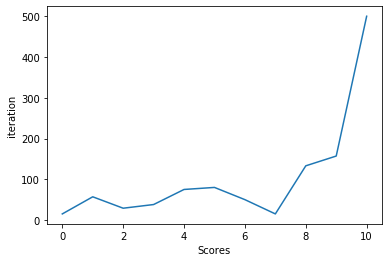

In [5]:
scores = deque(maxlen=30)
def cross_entropy(n_episode = 30, n_iter=1000, sigma = 0.5, batch_per_epi=10):
    best_weight = sigma*np.random.randn(agent.get_wights_dim())
    global scores
    for i in range(n_episode):
        memory = [best_weight + sigma*np.random.randn(agent.get_wights_dim()) for _ in range(batch_per_epi)]
        reward = [agent.evaluate(weight, n_iter) for weight in memory]
        best_weight_pos = np.array(reward).argsort()[-1]
        best_weight = memory[best_weight_pos]
        reward = agent.evaluate(best_weight, n_iter)
        scores.append(reward)
        #print(agent.fc1.weight)
        print('\rAverage Score {}'.format(reward), end = '')
        torch.save(agent.state_dict(), 'checkpoint_hillclimb_cartpole.pth')
        if reward == 500.0:
            print(" Environment Solved in {} iteration ".format(i))
            break
        #averaging weights 
cross_entropy()

plt.plot(scores)
plt.xlabel('Scores')
plt.ylabel('iteration')
plt.show()

In [9]:
agent.load_state_dict(torch.load('checkpoint_hillclimb_cartpole.pth'))
state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent.forward(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

/home/oxygen/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
